In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#import os
#os.chdir('/content/gdrive/My Drive/lucho/shop-recommender/')

Alguns links interessantes para entender o conceito do modelo

https://towardsdatascience.com/an-extensive-introduction-to-image-embedding-and-auto-encoders-0-6-5c5d9a18fcaa

https://towardsdatascience.com/leaky-relu-vs-relu-activation-functions-which-is-better-1a1533d0a89f

https://arxiv.org/pdf/2103.07085.pdf

https://medium.com/analytics-vidhya/image-similarity-model-6b89a22e2f1a (Abordagem utilizando KMeans, porém como o banco de UIs é muito diversificado iria ser criado muitas classes)

In [1]:
from tensorflow.config.experimental import list_physical_devices, set_memory_growth
physical_devices = list_physical_devices('GPU')
if len(physical_devices) > 0:
    set_memory_growth(physical_devices[0], True)

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
from difflib import SequenceMatcher
from PIL import Image
import os, sys



2022-12-10 21:05:33.907572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 21:05:33.914059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 21:05:33.914637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Data

In [2]:
#path = "./dir_001/"
#dirs = os.listdir( path )

#def resize():
#    for item in dirs:
#        if os.path.isfile(path+item):
#            im = Image.open(path+item)
#            f, e = os.path.splitext(path+item)
#            imResize = im.resize((256,256), Image.ANTIALIAS)
#            name = item.split(".")
#            imResize.save('./dir_001_resized/'+ name[0] + '_resized.jpg', 'JPEG', quality=90)

#resize()

In [8]:
# Load images
img_height = 64
img_width = 64
channels = 3
batch_size = 8
dataset_path = './dataset/'
train_datagen = ImageDataGenerator(#rotation_range=40,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   rescale=1./255,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   #horizontal_flip=True,
                                   #fill_mode='nearest',
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(
     dataset_path,
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

validation_set = train_datagen.flow_from_directory(
     dataset_path,
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'validation',
     shuffle=False)

Found 8000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.


## Modelo

A arquitetura do modelo contém três partes:
- Codificador (Encoder)
- Espaço Latente (Latent Space)
- Decodificador (Decoder)

### Codificador
- Conv2D = Extração de Features
- LeakyReLU = Função de Ativação, uma versão melhorada da Relu.
- BatchNormalization = Normalização das imagens.
- Flatten

### Espaço Latente
- Dense

### Decodificador

- Dense
- Reshape
- Conv2DTranspose
- LeakyReLU
- BatchNormalization
- Activation




In [10]:
# Define the autoencoder
input_model = Input(shape=(img_height, img_width, channels))

# Encoder layers
encoder = Conv2D(32, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder_dim = K.int_shape(encoder)
encoder = Flatten()(encoder)

# Latent Space
latent_space = Dense(16, name='latent_space')(encoder)

# Decoder Layers
decoder = Dense(np.prod(encoder_dim[1:]))(latent_space)
decoder = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(3, (3, 3), padding="same")(decoder)
output = Activation('sigmoid', name='decoder')(decoder)

# Create model object
autoencoder = Model(input_model, output, name='autoencoder')

# Model Summary
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_20 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 flatten_3 (Flatten)         (None, 262144)            0         
                                                                 
 latent_space (Dense)        (None, 16)                4194320   
                                                       

In [11]:
# Compile the model
autoencoder.compile(loss="mse", optimizer= Adam(learning_rate=1e-3))

# Fit the model
history = autoencoder.fit(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=25,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size)

# Save model


Epoch 1/25
1000/1000 [==============================] - 43s 42ms/step - loss: 0.0432 - val_loss: 0.0327
Epoch 2/25
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0320 - val_loss: 0.0304
Epoch 3/25
1000/1000 [==============================] - 41s 41ms/step - loss: 0.0309 - val_loss: 0.0302
Epoch 4/25
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0300 - val_loss: 0.0292
Epoch 5/25
1000/1000 [==============================] - 41s 41ms/step - loss: 0.0296 - val_loss: 0.0305
Epoch 6/25
1000/1000 [==============================] - 39s 39ms/step - loss: 0.0291 - val_loss: 0.0287
Epoch 7/25
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0286 - val_loss: 0.0284
Epoch 8/25
1000/1000 [==============================] - 43s 43ms/step - loss: 0.0282 - val_loss: 0.0304
Epoch 9/25
1000/1000 [==============================] - 41s 41ms/step - loss: 0.0278 - val_loss: 0.0279
Epoch 10/25
1000/1000 [==============================] - 41s 41m

### Model Performance

In [12]:
autoencoder.save('models/image_autoencoder_4.h5')

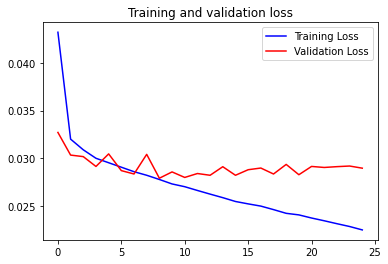

In [13]:
# Plot Accuracy and Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(loss))
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [14]:
autoencoder = load_model('models/image_autoencoder_4.h5', compile=False)

In [15]:
# Predict image function
def predict_image(image_dir, autoencoder):
  raw_image = load_img(image_dir, target_size=(img_width, img_height))
  image = img_to_array(raw_image)
  image = np.expand_dims(image, axis=0)
  image = image / 255.0
  pred = autoencoder.predict(image)
  pred = pred * 255.0
  pred = np.reshape(pred, (img_width, img_height, 3))
  pred = array_to_img(pred)

  return raw_image, pred


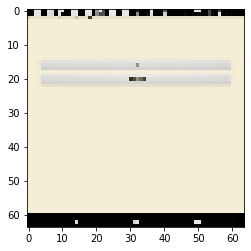

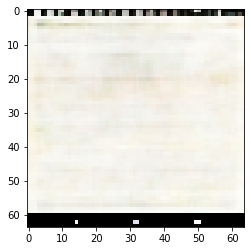

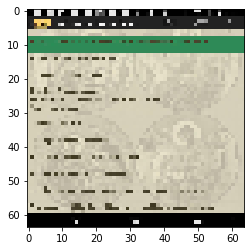

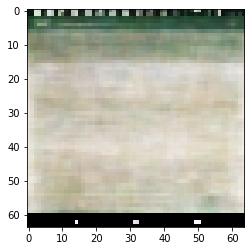

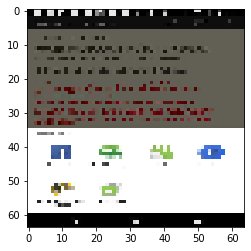

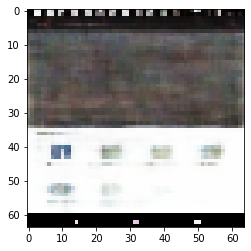

In [16]:
# Predict 3 images from training set
train_imgs = training_set.filepaths[0:3]

for i in train_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()

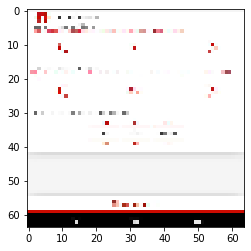

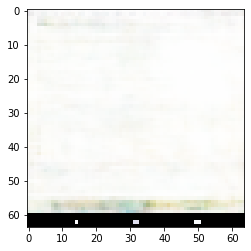

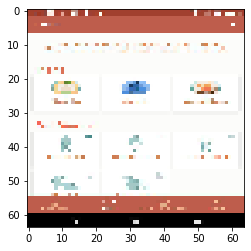

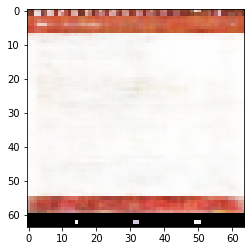

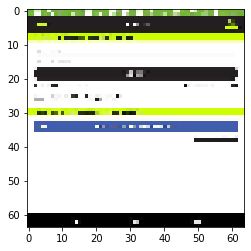

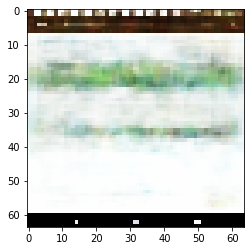

In [17]:
# Predict 3 images from validation set
val_imgs = validation_set.filepaths[0:3]

for i in val_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()

# Latent Space

Get the `latent space`layer prediction for every image, and export those vectors.

We are then going to compare those vectors to find similar images

In [18]:
# Create model with latent space layer
autoencoder = load_model('models/image_autoencoder_4.h5', compile=False)
latent_space_model = Model(autoencoder.input, autoencoder.get_layer('latent_space').output)

In [ ]:
# Load all images and predict them with the latent space model
X = []
indices = []

for i in tqdm(range(len(os.listdir('./dataset/dir_001')))):
  try:
    img_name = os.listdir('./dataset/dir_001')[i]
    img = load_img('./dataset/dir_001/{}'.format(img_name), target_size = (img_width, img_height))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    pred = latent_space_model.predict(img)
    pred = np.resize(pred, (16))
    X.append(pred)
    indices.append(img_name)

    # Export the embeddings
    if i in [1,10,100,500,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,12000,13000,14000,15000,16000,17000,18000,19000]:
      embeddings = {'indices': indices, 'features': np.array(X)}

      pickle.dump(embeddings, open('./dataset/image_embeddings_2.pickle', 'wb'))

  except:
    print(img_name)


/tmp/ipykernel_75206/2334986550.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(os.listdir('./dataset/dir_001')))):


  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
# Export the embeddings
embeddings = {'indices': indices, 'features': np.array(X)}
pickle.dump(embeddings, open('./dataset/image_embeddings_2.pickle', 'wb'))

## Image Similarity
We will use the euclidean distance of the vectors to get the similar images

In [13]:
def eucledian_distance(x,y):
  eucl_dist = np.linalg.norm(x - y)
  return eucl_dist

def category_similarity(x,y):
  return SequenceMatcher(None, x, y).ratio()

In [14]:
# Load embeddings
embeddings = pickle.load(open('./dataset/image_embeddings_2.pickle', 'rb'))

# Load images metadata
#metadata = pd.read_csv('flipkart/metadata.csv')

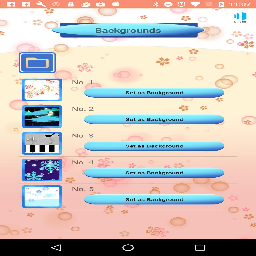

In [20]:
# Get image name
img_name = os.listdir('./dataset/dir_001')[222]
img = load_img('./dataset/dir_001/{}'.format(img_name), target_size=(64, 64))
show = load_img('./dataset/dir_001/{}'.format(img_name), target_size=(256,256))
show

/tmp/ipykernel_4199/4206413895.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/10000 [00:00<?, ?it/s]

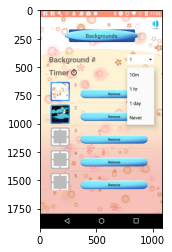

Euclidean Distance: 889.818115234375


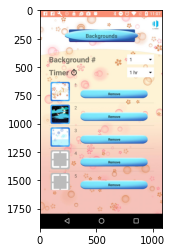

Euclidean Distance: 929.539794921875


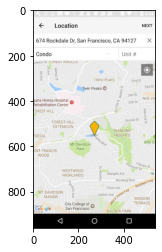

Euclidean Distance: 2131.515380859375


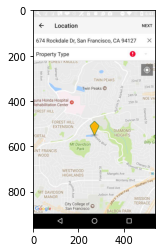

Euclidean Distance: 2173.32275390625


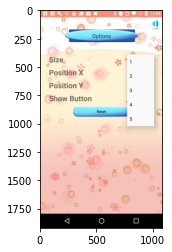

Euclidean Distance: 2242.9404296875


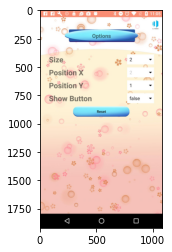

Euclidean Distance: 2281.6123046875


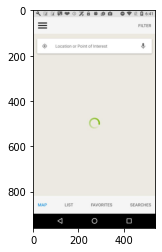

Euclidean Distance: 2282.048095703125


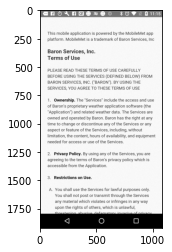

Euclidean Distance: 2313.486083984375


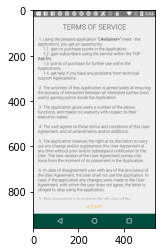

Euclidean Distance: 2335.000244140625


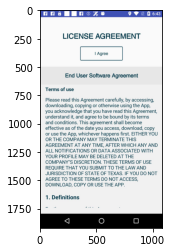

Euclidean Distance: 2349.783935546875


In [21]:
# Calculate eucledian distance
img_similarity = []
cat_similarity = []

# Get actual image embedding
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
pred = latent_space_model.predict(img)
pred = np.resize(pred, (16))
#img_cat = metadata.query("id == '{}'".format(img_name.replace('.jpg','')))['category'].values[0]
#print('Image Category: {}'.format(img_cat))

for i in tqdm(range(len(embeddings['indices']))):
  img_name = embeddings['indices'][i]

  # Calculate vectors distances
  dist = eucledian_distance(pred,embeddings['features'][i])
  img_similarity.append(dist)

  # Calculate categoy similarity
  #cat = metadata.query("id == '{}'".format(img_name.replace('.jpg','')))['category'].values[0]
  #cat_sim = category_similarity(img_cat, cat)
  #cat_similarity.append(cat_sim)

imgs_result = pd.DataFrame({'img': embeddings['indices'],
                            'euclidean_distance': img_similarity})


imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
#imgs_result = imgs_result.iloc[0:20,:].sort_values(by='category_similarity', ascending=False).reset_index(drop=True)

# Show 10 first similar images
for i in range(10):
  image = load_img('./dataset/dir_001/{}'.format(imgs_result['img'].values[i]))
  #category = metadata.query("id == '{}'".format(imgs_result['img'].values[i].replace('.jpg','')))['category'].values[0]
  
  # Show image
  plt.imshow(image)
  plt.show()
  #print('Image Category: {}'.format(category))
  print('Euclidean Distance: {}'.format(imgs_result['euclidean_distance'].values[i]))
  #print('Category Distance: {}'.format(imgs_result['category_similarity'].values[i]))

In [22]:
imgs_result

,img,euclidean_distance
0,15528.jpg,889.818115
1,15524.jpg,929.539795
2,16883.jpg,2131.515381
3,16892.jpg,2173.322754
4,15530.jpg,2242.940430
...,...,...
9994,15091.jpg,13995.424805
9995,12429.jpg,14056.112305
9996,13880.jpg,14451.247070
9997,19499.jpg,14680.909180
